In [1]:
import legume
import legume.fields as fields
import pickle
import numpy as np

import matplotlib.pyplot as plt

# Chickpea Fields: Waveguides
The Chickpea.fields is module provides a class for manipulating and managing field profiles of solutions of
guided mode expansions generated by legume.

We will now investigate some of its features by analyzing a photonic crystal waveguides.

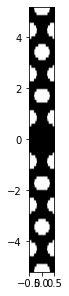

In [2]:
Nx, Ny = 1, 12

# Regular PhC parameters
dslab = 1.2
ra = 0.3
epsr = 12.0

# Initialize a lattice and PhC
lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(1,ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

phc = legume.PhotCryst(lattice)

phc.add_layer(d=dslab, eps_b=epsr)

for ic, x in enumerate(xp):
    yc = yp[ic]
    xc = xp[ic]
    phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
    if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:

        phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
    if nx-1.6 > xp[ic] > 0:
        phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
    if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))

legume.viz.eps(phc.layers[-1])

We now generate the guided mode expansion solutions.

Setting Generate to True will regenerate the gme object with solutions. Otherwise, it will be loaded from the aux_files folder.

In [3]:
# Number of PhC periods in x and y directions

gme = legume.GuidedModeExp(phc = phc)
numeig=2
options = {'gmode_inds': [0],
           'verbose': True,
           'eig_solver': 'eigsh',
           'eig_sigma': 0.26,
           'numeig': numeig,
           'gradients': 'approx',
           'compute_im': False}

gme.run(np.array([[np.pi*3/4, -np.pi*3/4],[0, 0]]),**options)
pickle.dump(gme, open("./aux_files/Field_Tutorial_GME_WG.p", 'wb'))

0.5041s total time for real part of frequencies, of which
  0.2070s for matrix construction
  0.1530s for guided modes computation using the gmode_compute='exact' method
  0.0110s for inverse matrix of Fourier-space permittivity
  0.0720s for matrix diagionalization using the 'eigsh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


We will now generate the mode profiles of the modes we generated using the XYfield object.

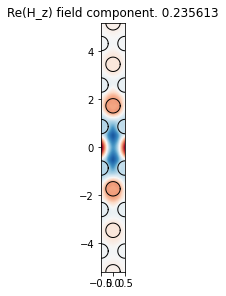

In [4]:
res = 20*np.array([Nx, Ny])
field_1 = fields.XYField(res = res, # The resolution of the field profile (x,y)
                         z_dimension=dslab/2, # The location of the cross section in the slab.
                                              # Here we choose the center of the slab.
                         polarization='TE', # The polarization of the field. In the 'TE' case the constructor generates
                                            # the H_z and E_x E_y components setting other components to zero.

                         gme=gme, mind=0, kind=0,
                         modulation = [np.pi*3/4,0]
                         )

fig_hz = field_1.visualize_field(field='h', component='z', val='re')
fig_hz.axes[0].set_title('Re(H_z) field component. %f' % field_1.freq)
plt.show()


We have generated two modes that are propagating down the waveguide.
To confirm they are propagating one might want to analyze the Poynting vector field generated by the modes.

This can be done using the poynting_vector field method of the XYfield class.

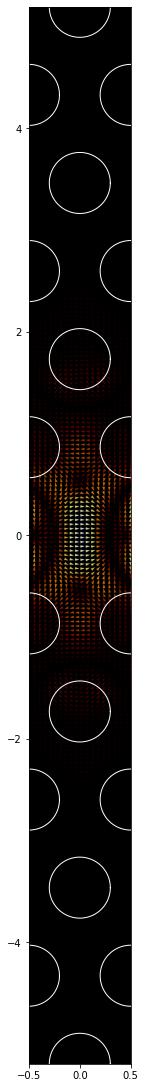

In [5]:
pv_field = field_1.poynting_vector(time = 0)

fig_pv = field_1.visualize_poynting_vector(time = 0, figsize=(3,15))

We can reduce the number of vectors displayed by introducing the pv_coarseness field.
Which lowpass downsamples the field to reduce the number of gridpoints by a factor of pv_coarseness.

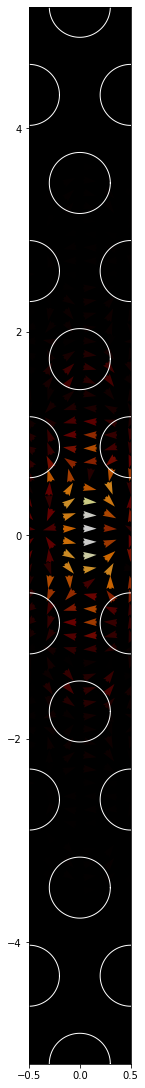

In [6]:
pv_field = field_1.poynting_vector(time = 0)
pv_coarseness=3

fig_pv = field_1.visualize_poynting_vector(time = 0, figsize=(3,15), pv_coarseness=pv_coarseness)

Further note that this is the poynting vector field at time = 0 to get the time averaged poynting vector field use the
time_avg_pv method.

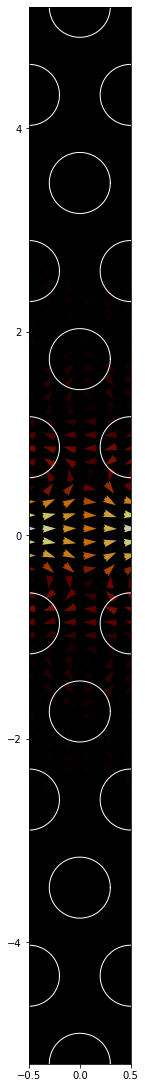

In [7]:
pv_coarseness=3

tpv = field_1.time_avg_pv(period=2*np.pi/field_1.freq, N_samples=50)

fig_tpv = field_1.visualize_time_avg_pv(period=2*np.pi/field_1.freq, N_samples=50, pv_coarseness=pv_coarseness, figsize=(3,15))

Another metric of note may be the chirality of the field. The chirality is a measure of the
polarization of the field defined $\vec{E}^*\times \vec{E}$. In the case of a TE field we would be interested in the
z component of the transverse electric field.

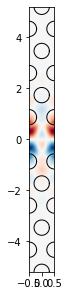

In [8]:
fig_chi = field_1.vizualize_chirality(field='e', component='z')

## Modulation
Suppose we are interested in a higher k vector mode of the mode we visualized. We can easily modulate the field
using the \_\_mult__ operand of the XYfield class.

For instance let's visualize the next x spatial frequency of the field_1 bloch mode.

C:\Users\stephen\AppData\Local\Temp/ipykernel_11784/2171400033.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_mod.show()


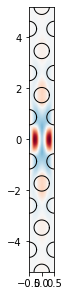

In [9]:
modulation = np.exp(-1j*field_1.meshgrid[0]*2*np.pi)

field_modulated = field_1 * modulation # It's important to multiply the XYfield by the array,
                                       # otherwise the XYfield will be broadcast into the numpy array.

fig_mod = field_modulated.visualize_field(field='h', component='z', val='re')

fig_mod.show()

## Superposition
Now suppose we are interested in the superposition of two fields.
Perhaps the propagating and counter propagating modes of a photonic crystal ring resonator or whispering gallery mode.

This can be done using the \_\_add__ and \_\_sub__ operands of the XYfield class.

To demonstrate let us take the even and odd superposition of a leftward and rightward propagating mode of the
second waveguide mode.

It can be helpful to use the 'renormalization' entry in the constructor to normalize the field.
This makes the max magnitude point equal to 1 at t=0.

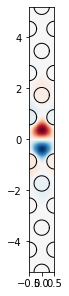

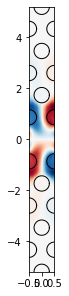

In [40]:
field_2_right = fields.XYField(res = res, # The resolution of the field profile (x,y)
                         z_dimension=dslab/2, # The location of the cross section in the slab.
                                              # Here we choose the center of the slab.
                         polarization='TE', # The polarization of the field. In the 'TE' case the constructor generates
                                            # the H_z and E_x E_y components setting other components to zero.

                         gme=gme, mind=1, kind=0,
                         modulation = [np.pi*3/4,0],
                         renormalize=True
                         )
field_2_left = fields.XYField(res = res, # The resolution of the field profile (x,y)
                         z_dimension=dslab/2, # The location of the cross section in the slab.
                                              # Here we choose the center of the slab.
                         polarization='TE', # The polarization of the field. In the 'TE' case the constructor generates
                                            # the H_z and E_x E_y components setting other components to zero.

                         gme=gme, mind=1, kind=1,
                         modulation = [-np.pi*3/4,0],
                         renormalize=True
                         )

field_even = field_2_right + field_2_left

field_odd = field_2_right - field_2_left

fig_even = field_even.visualize_field(field='h', component='z')
fig_odd = field_odd.visualize_field(field='h', component='z')

If we investigate the integral of the time averaged Poynting vector we see that it is close to zero
as expected for standing waves.

In [41]:
tpv_even=field_even.time_avg_pv(period=2*np.pi/field_even.freq, # Note that the frequency of composite fields is not
                                                                # necessarily well defined.
                                                                # Only if the frequencies of both modes are sufficiently
                                                                # close is the frequency passed to the composite field.
                                           N_samples=100)
tpv_odd=field_odd.time_avg_pv(period=2*np.pi/field_odd.freq,
                                           N_samples=100)
tpv_right = field_2_right.time_avg_pv(period=2*np.pi/field_2_right.freq,
                                           N_samples=100)

print("tpv_even: " + str(np.sum(tpv_even[0])))
print("tpv_odd: " + str(np.sum(tpv_odd[0])))
print("tpv_right: " + str(np.sum(tpv_right[0])))

tpv_even: 0.013147926127849385
tpv_odd: 0.013147928013208248
tpv_right: 8.210779553557227
